# Project: Machine Learning (CSCI-4734)
## Epileptic Seizure Classification Using EEG Data from the BEED Dataset
### Team 4 Members:
**Laman Panakhova,**
**Nariman Mammadov,**
**Zaur Rajabov**

#### School of Information Technologies and Engineering, ADA University, Baku, Azerbaijan


#### Why?, What?, How?
Each step includes a **Why?**, **What?**, and **How?** to make sure you understand:
- **Why** we’re doing each task
- **What** we’re actually doing
- **How** we’re doing it, including the specific methods or functions we use

This way, you'll not only follow the steps but also understand the reasoning behind each one. It’ll help you get a clearer idea of how to apply these techniques to your own projects in the future!

This project aims to build a *robust and interpretable machine-learning model* for classifying brain electrical activity (EEG) from the **BEED dataset**.

We follow a complete ML pipeline:

1. **Loading & Inspecting the Data**  
2. **Exploratory Data Analysis (EDA)**  
3. **Feature Engineering**  
4. **Data Preprocessing & Scaling**  
5. **Model Training with Hyperparameter Tuning**  
6. **Soft Voting Ensemble Model**  
7. **Comprehensive Evaluation (Accuracy, F1, ROC, PR, Confusion Matrix)**  
8. **Explainability using SHAP & LIME**  
9. **Model Tracking with MLflow**  
10. **Visual Insights, Feature Importance & PCA**  

The goal is to explore multiple ML models, compare them, and identify the most reliable and interpretable solution for EEG state classification.


#### Install and Import Dependencies
##### This cell installs all external libraries required for the project:
    SHAP, LIME, XGBoost, and Statsmodels. These packages are not included in base Python, so installing them here ensures reproducibility.
##### After installation, the following modules are imported:
    Data manipulation: pandas, numpy
    Visualization: matplotlib, seaborn
    Machine learning & preprocessing: scikit-learn
    Explainability tools: SHAP, LIME
    Statistical evaluation: McNemar’s test (statsmodels)
##### This sets up the complete environment for the machine learning pipeline.


In [2]:
# -------------------------
# 0. Install libraries & import tools
# -------------------------
# WHAT: Install required ML packages (only needed once).
# WHY: Some libraries (SHAP, LIME, XGBoost) may not be pre-installed in Jupyter.
# HOW: pip install command inside notebook.

!pip install shap lime statsmodels xgboost

# Standard imports
import os, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# sklearn tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, auc, precision_recall_curve)

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer

from scipy.stats import zscore
from statsmodels.stats.contingency_tables import mcnemar

RSEED = 42


    Objective: Load the BEED EEG dataset from a CSV file for analysis and machine learning.
    Method: Use pandas.read_csv() to load the data into a DataFrame.
    Why: To examine the data structure, check for missing values, and start the data preprocessing.

In [4]:
# -------------------------
# 1. Load Data
# -------------------------
# WHAT: Load BEED EEG dataset from file.
# WHY: To analyze, clean, build ML models.
# HOW: Using pandas read_csv().

data_path = r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Machine Learning (CSCI-4734 - 10859)\BEED_Data.csv"

df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (8000, 17)


X1   X2   X3   X4   X5   X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  \
0    4    7   18   25   28   27  20  10 -10  -18  -20  -16   13   32   12   
1   87  114  120  106   76   54  28   5 -19  -49  -85 -102 -100  -89  -61   
2 -131 -133 -140 -131 -123 -108 -58 -51 -70  -77  -76  -76  -73  -57  -40   
3   68  104   73   34  -12  -26 -38 -36 -67  -88  -25   31   18   -4    6   
4  -67  -90  -97  -94  -86  -71 -43 -11  23   46   58   50   39   19   -9   

   X16  y  
0   10  0  
1  -21  0  
2  -14  0  
3  -29  0  
4  -41  0

    WHAT: In this section, we conduct exploratory data analysis (EDA).
    WHY: EDA helps us to understand the data better by checking class distribution, identifying missing values, and reviewing the overall data statistics.
    HOW: We check the class distribution of the target variable (y) to identify any class imbalance.
    We inspect the data for missing values to know if any rows/columns need cleaning.
    We display summary statistics (e.g., min, median, and max values) to understand the range and spread of the numerical data.

In [4]:
# -------------------------
# 2. Exploratory Data Analysis (EDA)
# -------------------------

# WHAT: Check target distribution
print("Class counts:\n", df['y'].value_counts())

# WHAT: Look for missing data
print("\nMissing values:\n", df.isna().sum())

# WHAT: Five-number summary
display(df.describe(percentiles=[.25, .5, .75]).T)


Class counts:
 y
0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64

Missing values:
 X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
y      0
dtype: int64


count      mean        std    min    25%  50%    75%    max
X1   8000.0 -1.490375  36.824213 -281.0  -7.00  0.0   8.00  252.0
X2   8000.0 -2.189375  36.108088 -255.0  -7.00  0.0   8.00  261.0
X3   8000.0 -3.237500  35.802490 -255.0  -7.00 -1.0   5.00  238.0
X4   8000.0 -4.119375  36.285268 -257.0 -10.00 -1.0   7.00  246.0
X5   8000.0 -1.821625  37.621284 -264.0 -10.00  0.0  10.00  249.0
X6   8000.0 -2.311750  36.306006 -277.0  -8.00  0.0   8.00  245.0
X7   8000.0 -3.398125  36.358395 -277.0  -8.00 -1.0   6.00  220.0
X8   8000.0 -3.448625  36.522214 -260.0  -7.00 -1.0   5.00  271.0
X9   8000.0 -1.647875  38.107721 -290.0  -7.00  0.0   8.00  280.0
X10  8000.0 -2.561250  37.540680 -302.0  -8.00  0.0   8.00  251.0
X11  8000.0 -3.524500  37.343938 -276.0  -8.00 -1.0   5.00  262.0
X12  8000.0 -4.782750  37.469582 -306.0 -11.00 -2.0   7.00  283.0
X13  8000.0 -2.164000  38.144075 -288.0 -10.00  0.0  10.00  296.0
X14  8000.0 -2.910875  36.640555 -290.0  -8.00  0.0   9.00  291.0
X15  8000.0 -4.355375  36.242793 -323.0  -9.00 -2.0   5.00  251.0
X16  8000.0 -4.113750  35.933601 -317.0  -6.00 -1.0   4.00  270.0
y    8000.0  1.500000   1.118104    0.0   0.75  1.5   2.25    3.0

    2.4 Histograms
    Purpose: Visualize the distribution of each feature in the dataset.
    Method: Plot histograms for each feature (except the target variable) to examine how the data is spread.
    
    2.5 Boxplots
    Purpose: Detect potential outliers in the data.
    Method: Plot boxplots for all features to visually identify any outliers.
    
    Z-score Outlier Detection
    Purpose: Quantify outliers using Z-scores (values > 3 standard deviations from the mean).
    Method: Calculate the Z-scores for each feature and count how many samples have outliers.

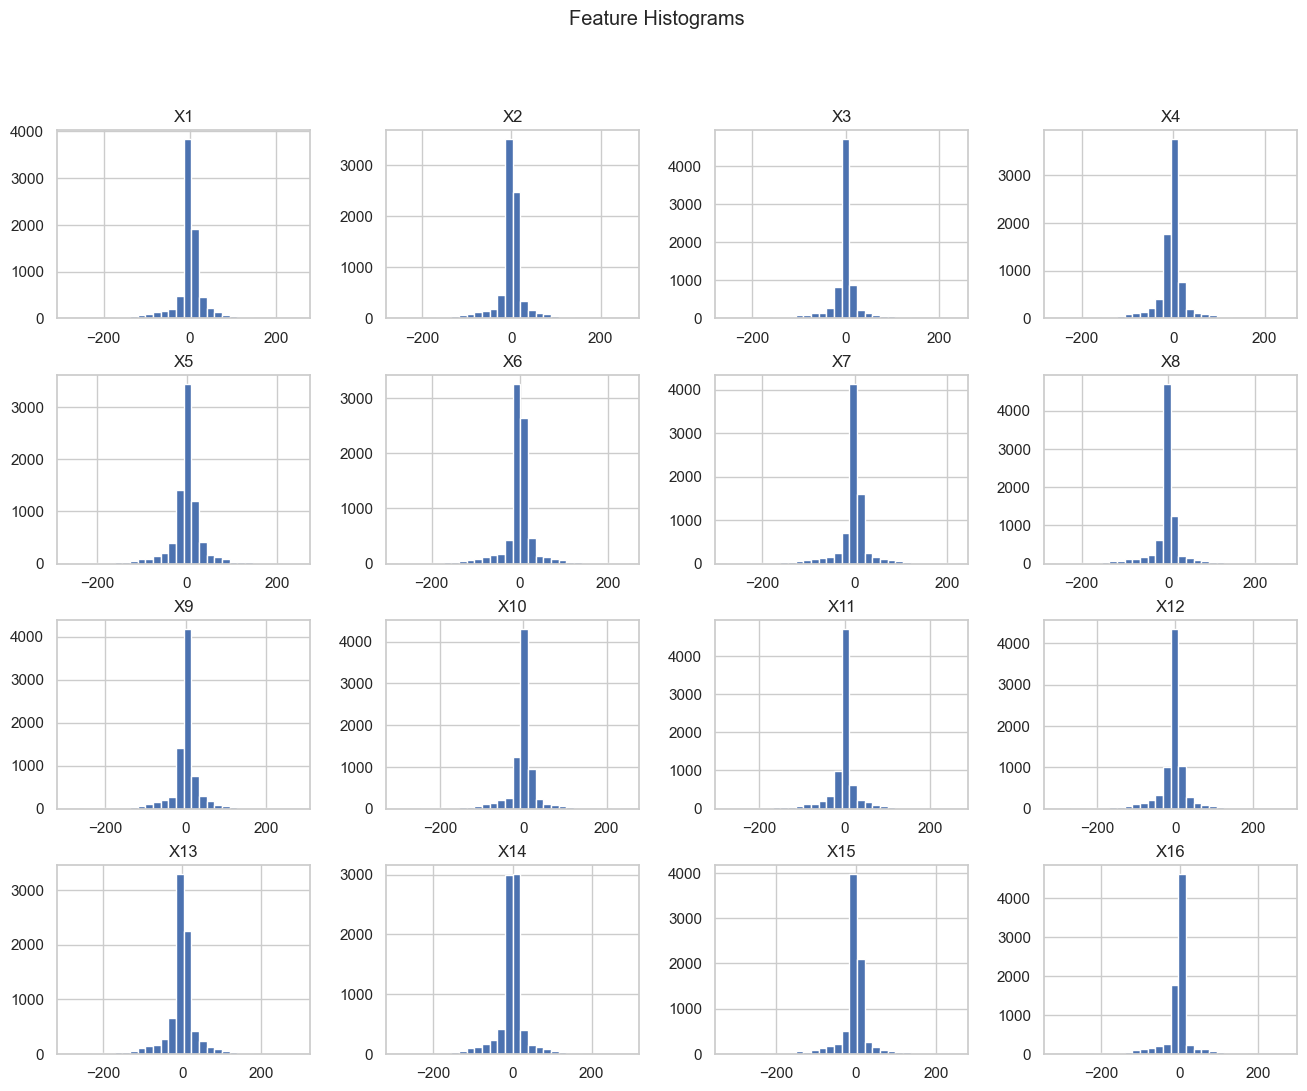

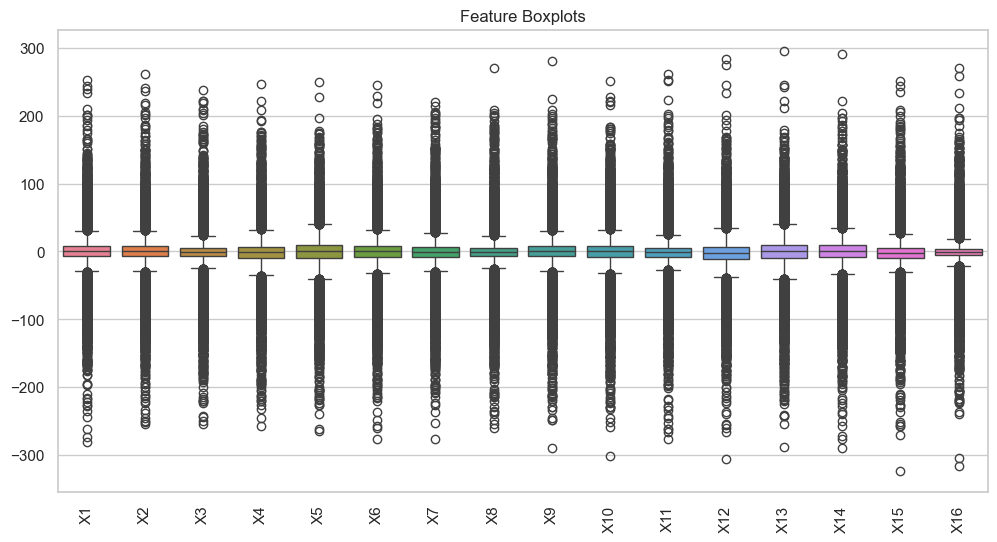

Samples with outliers: 873


In [5]:
# -------------------------
# 2.4 Histograms
# -------------------------
# WHY: Helps visualize distribution of each feature.

df.iloc[:, :-1].hist(bins=30, figsize=(16,12))
plt.suptitle("Feature Histograms")
plt.show()

# -------------------------
# 2.5 Boxplots
# -------------------------
# WHY: Detect outliers visually.

plt.figure(figsize=(12,6))
sns.boxplot(data=df.drop(columns='y'))
plt.xticks(rotation=90)
plt.title("Feature Boxplots")
plt.show()

# Z-score outlier count
z_scores = np.abs(zscore(df.iloc[:, :-1]))
outliers = (z_scores > 3).sum(axis=1)
print("Samples with outliers:", (outliers > 0).sum())


    2.7 Pairplot (for smaller datasets)
    Purpose: Visualize relationships between features and the target variable using pairwise scatter plots.
    Why: Useful for smaller datasets to inspect interactions and correlations between features.
    Method: Use sns.pairplot() to plot pairwise relationships for a random sample of the data, color-coded by the target variable.

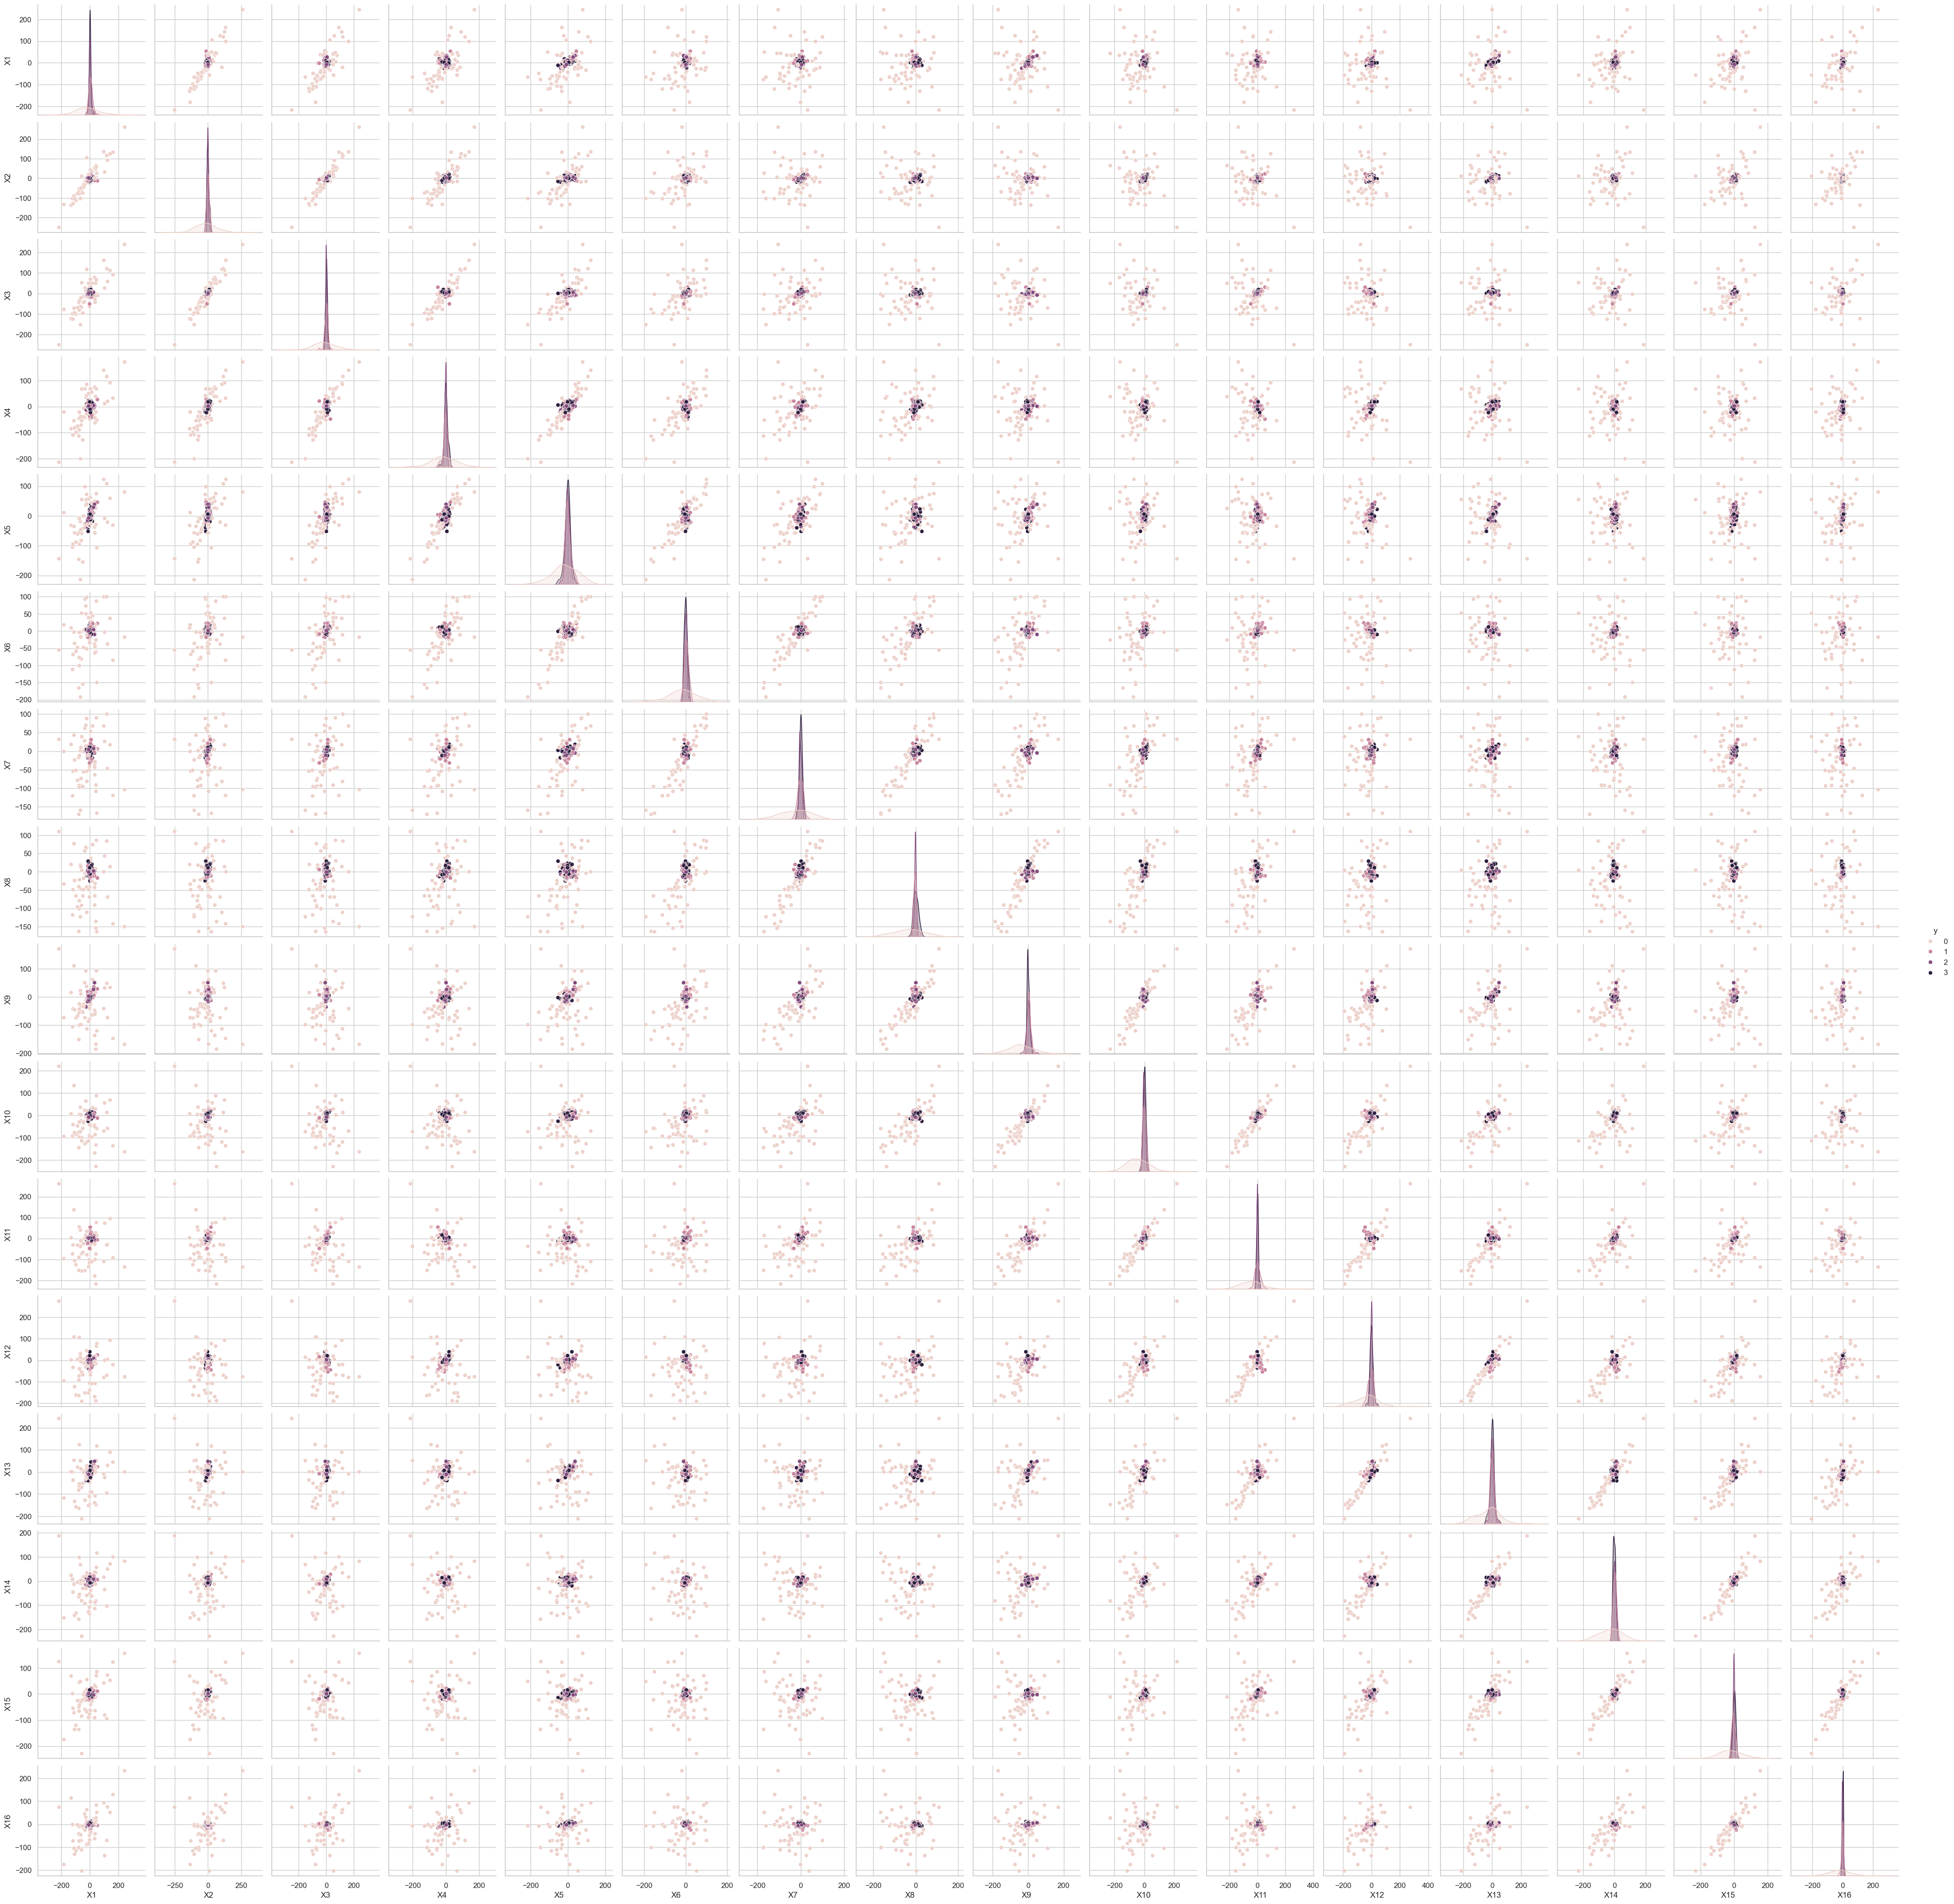

In [11]:
# -------------------------
# 2.7 Pairplot (for smaller datasets)
# -------------------------
# WHAT: Visualize relationships between features with a pairplot.
# WHY: Helpful for smaller datasets to inspect feature interactions.

sns.pairplot(df.sample(min(200,len(df))), hue='y', diag_kind='kde')
plt.show()


    Correlation
    Purpose: Visualize correlations between features to identify strong relationships.
    Why: Understanding feature correlations helps in feature selection and understanding how features interact.
    Method: Use a heatmap (sns.heatmap()) to display the correlation matrix for all features (excluding the target variable), with colors indicating strength and direction of correlations.

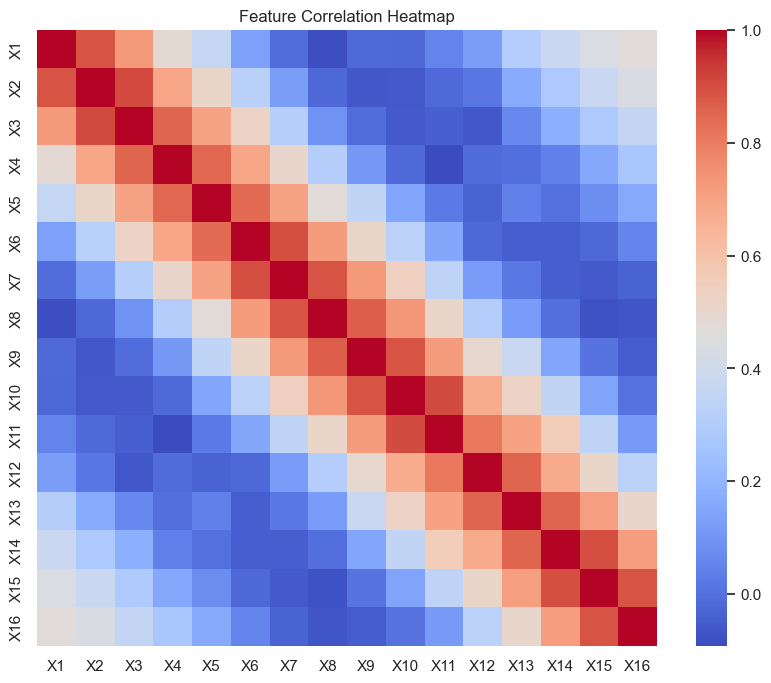

In [37]:
# -------------------------
# Correlation
# -------------------------
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns='y').corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

    3. Feature Engineering
    Purpose: Create new statistical features to enhance the model’s predictive power.
    Why: Adding features like mean, standard deviation, energy, etc., can provide more informative patterns for the model, boosting its accuracy.
    Method: We calculate various statistical features for each sample:
    Mean (x_mean), Standard Deviation (x_std), Energy (x_energy), Peak-to-Peak (x_ptp), Absolute Sum (x_abs_sum), Skewness (x_skew), and Kurtosis (x_kurt) across all features (excluding the target variable).

In [7]:
# -------------------------
# 3. Feature Engineering
# -------------------------
# WHAT: Create new "statistical" features.
# WHY: Boost model accuracy by adding meaningful information.

df_fe = df.copy()
cols = df.columns[:-1]

df_fe['x_mean'] = df_fe[cols].mean(axis=1)
df_fe['x_std'] = df_fe[cols].std(axis=1)
df_fe['x_energy'] = (df_fe[cols]**2).sum(axis=1)
df_fe['x_ptp'] = df_fe[cols].max(axis=1) - df_fe[cols].min(axis=1)
df_fe['x_abs_sum'] = df_fe[cols].abs().sum(axis=1)
df_fe['x_skew'] = df_fe[cols].skew(axis=1)
df_fe['x_kurt'] = df_fe[cols].kurtosis(axis=1)

print("New shape:", df_fe.shape)
display(df_fe.head())


New shape: (8000, 24)


X1   X2   X3   X4   X5   X6  X7  X8  X9  X10  ...  X15  X16  y   x_mean  \
0    4    7   18   25   28   27  20  10 -10  -18  ...   12   10  0   8.8750   
1   87  114  120  106   76   54  28   5 -19  -49  ...  -61  -21  0   4.0000   
2 -131 -133 -140 -131 -123 -108 -58 -51 -70  -77  ...  -40  -14  0 -84.8750   
3   68  104   73   34  -12  -26 -38 -36 -67  -88  ...    6  -29  0   0.5625   
4  -67  -90  -97  -94  -86  -71 -43 -11  23   46  ...   -9  -41  0 -23.3750   

       x_std  x_energy  x_ptp  x_abs_sum    x_skew    x_kurt  
0  16.899211      5544     52        270 -0.536374 -0.843899  
1  80.796040     98176    222       1116  0.109852 -1.548884  
2  38.178310    137124    126       1358 -0.013457 -0.995126  
3  51.971747     40521    192        659  0.375548 -0.254274  
4  56.951295     57394    155        844  0.080172 -1.649710  

[5 rows x 24 columns]

    4. Train/Test Split + Scaling
    Purpose: Split data into training and testing sets, then scale features.
    Why: Prevent overfitting and ensure features are on the same scale.
    Method: Split data (80% train, 20% test) using stratified sampling.
    Scale features using StandardScaler.

In [8]:
# -------------------------
# 4. Train/Test Split + Scaling
# -------------------------
# WHY: ML models need train/test separation to avoid overfitting.

X = df_fe.drop(columns='y')
y = df_fe['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

# StandardScaler normalizes data for ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


    5. Models & Hyperparameters
    Purpose: Define machine learning models and their hyperparameter grids for tuning.
    Why: We use GridSearchCV to find the best hyperparameters that maximize model performance.
    Method: Define a variety of models (Logistic Regression, SVM, Decision Tree, etc.) and their respective hyperparameter grids for tuning.

In [9]:
# -------------------------
# 5. Models & Hyperparameters
# -------------------------
# WHAT: Define ML models and tuning grids.
# WHY: We use GridSearchCV to find best hyperparameters.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

models = {
    "LogReg": LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial'),
    "SVM_RBF": SVC(kernel='rbf', probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

param_grids = {
    "LogReg": {'C':[0.01,0.1,1,10]},
    "SVM_RBF": {'C':[0.1,1,10], 'gamma':['scale',0.01]},
    "DecisionTree": {'max_depth':[5,10,20,None]},
    "RandomForest": {'n_estimators':[100,300]},
    "KNN": {'n_neighbors':[3,5,7]},
    "GradientBoosting": {'n_estimators':[100,300]},
    "XGBoost": {'n_estimators':[100,300], 'max_depth':[3,5]}
}


    Grid Search Function
    Purpose: Perform hyperparameter tuning using GridSearchCV.
    Why: GridSearchCV helps identify the best hyperparameters for each model by evaluating them across multiple cross-validation folds.
    Method: Define a function cv_grid_search() that takes the model, its hyperparameter grid, and the training data to find the best model.
    For each model, perform GridSearchCV and store the best model in best_models.

In [10]:
# -------------------------
# Grid Search Function
# -------------------------

def cv_grid_search(name, model, grid):
    print(f"\nTuning {name} ...")
    gs = GridSearchCV(model, grid, scoring='f1_macro', cv=skf, n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_)
    return gs.best_estimator_

best_models = {}

for name, model in models.items():
    best_models[name] = cv_grid_search(name, model, param_grids[name])



Tuning LogReg ...
Best params: {'C': 10}

Tuning SVM_RBF ...
Best params: {'C': 10, 'gamma': 'scale'}

Tuning DecisionTree ...
Best params: {'max_depth': 20}

Tuning RandomForest ...
Best params: {'n_estimators': 300}

Tuning KNN ...
Best params: {'n_neighbors': 3}

Tuning GradientBoosting ...
Best params: {'n_estimators': 300}

Tuning XGBoost ...
Best params: {'max_depth': 5, 'n_estimators': 300}


    6. Soft Voting Ensemble
    Purpose: Combine the top models to create a more stable and robust classifier.
    Why: A soft voting ensemble averages the predicted probabilities of top models, improving performance and reducing overfitting.
    Method: Select the top 3 models from best_models and create a VotingClassifier using soft voting.
    Train the ensemble on the scaled training data.

In [12]:
# -------------------------
# 6. Soft Voting Ensemble
# -------------------------
# WHY: Combine top models → more stable performance.

top3 = list(best_models.keys())[:3]

voting_soft = VotingClassifier(
    [(n, best_models[n]) for n in top3], voting='soft'
)

voting_soft.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('LogReg',
                              LogisticRegression(C=10, max_iter=2000,
                                                 multi_class='multinomial',
                                                 solver='saga')),
                             ('SVM_RBF', SVC(C=10, probability=True)),
                             ('DecisionTree',
                              DecisionTreeClassifier(max_depth=20))],
                 voting='soft')

    7. Evaluation
    Purpose: Evaluate the performance of the trained model on the test set.
    Why: To assess how well the model generalizes to unseen data using metrics like accuracy, F1 score, and the confusion matrix.
    Method: Use the evaluate() function to calculate accuracy, F1 score (macro), and print the classification report.
    Plot a confusion matrix to visualize the model's predictions.

Accuracy: 0.8625
F1_macro: 0.86142683253419
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.85      0.89      0.87       400
           2       0.79      0.86      0.83       400
           3       0.82      0.71      0.76       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600



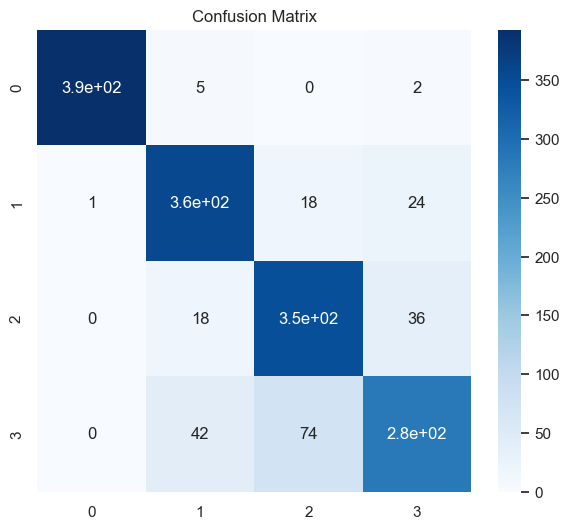

In [13]:
# -------------------------
# 7. Evaluation
# -------------------------
def evaluate(model):
    y_pred = model.predict(X_test_scaled)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1_macro:", f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred))
    return y_pred

pred = evaluate(voting_soft)

plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


    10. PCA Visualization with Centroids
    Purpose: Visualize the class centroids on the PCA plot to show the center of each class after dimensionality reduction.
    Why: Adding centroids helps in understanding how well-separated the classes are in the PCA-transformed space.
    Method: After performing PCA, calculate the centroids (mean positions) of each class and plot them on the scatterplot. The centroids are highlighted with a black 'X'.

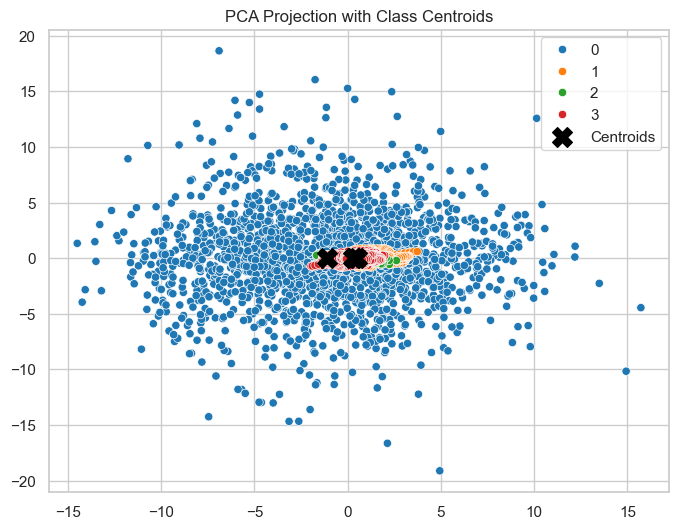

In [17]:
# -------------------------
# 10. PCA Visualization with Centroids
# -------------------------
# WHAT: Add class centroids to PCA visualization.
# WHY: Visualizes the center of each class after PCA transformation.
centroids = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "y": y
}).groupby("y").mean()

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='tab10')
plt.scatter(centroids.PC1, centroids.PC2, s=200, c='black', marker='X', label='Centroids')
plt.title("PCA Projection with Class Centroids")
plt.legend()
plt.show()


    ROC & PR Curves
    Purpose: Visualize model performance using ROC and Precision-Recall curves.
    Why: These curves provide a deeper understanding of the model’s performance across different class thresholds.
    Method: ROC Curves: Plot the True Positive Rate (TPR) vs. False Positive Rate (FPR) for each class.
    Precision-Recall Curves: Plot precision vs. recall for each class to evaluate performance on imbalanced datasets.

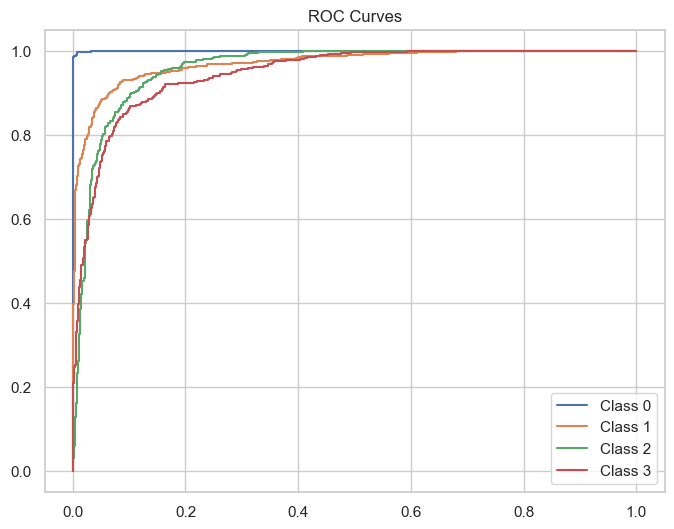

In [14]:
# -------------------------
# ROC & PR CURVES
# -------------------------
y_test_bin = pd.get_dummies(y_test).values
y_proba = voting_soft.predict_proba(X_test_scaled)

# ROC
plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_proba[:,i])
    plt.plot(fpr, tpr, label=f"Class {cls}")
plt.legend()
plt.title("ROC Curves")
plt.show()


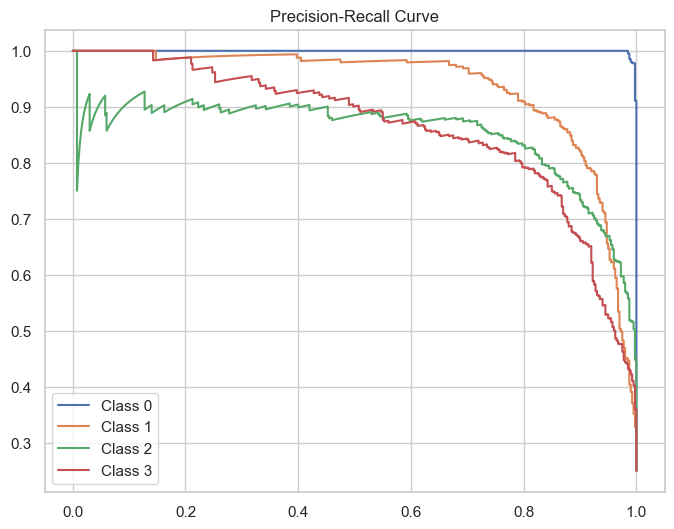

In [35]:
plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f"Class {cls}")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

    Feature Importance
    Purpose: Identify which features are most important for the Random Forest model.
    Why: Understanding feature importance helps with model interpretation and feature selection.
    Method: Plot the feature importances calculated by the Random Forest model using a bar chart.

    SHAP for XGBoost
    Purpose: Explain model predictions for XGBoost using SHAP values.
    Why: SHAP values provide detailed insights into how each feature impacts the prediction.
    Method: Use SHAP to explain the XGBoost model’s predictions and visualize the results with a summary plot.

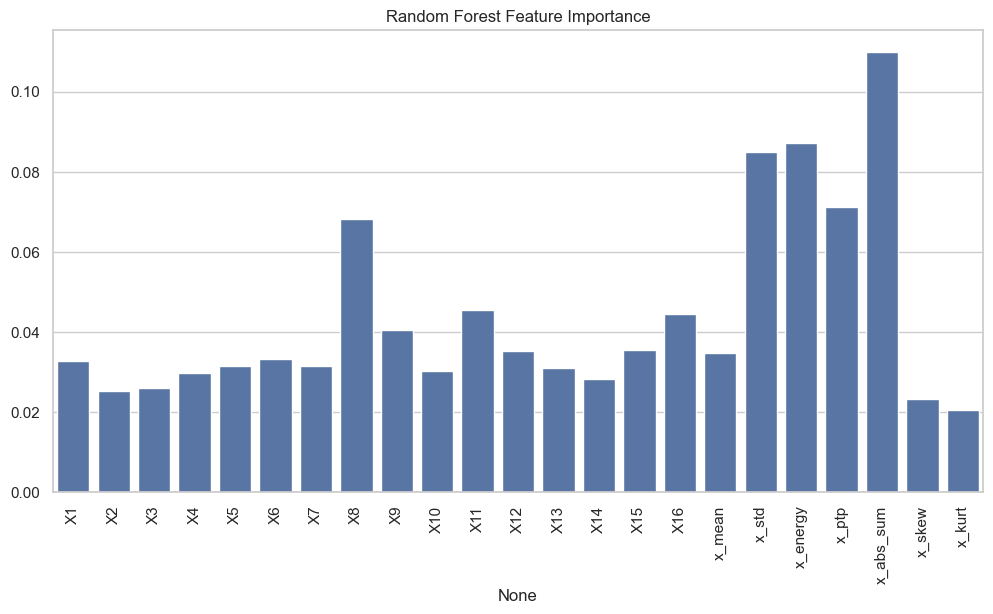

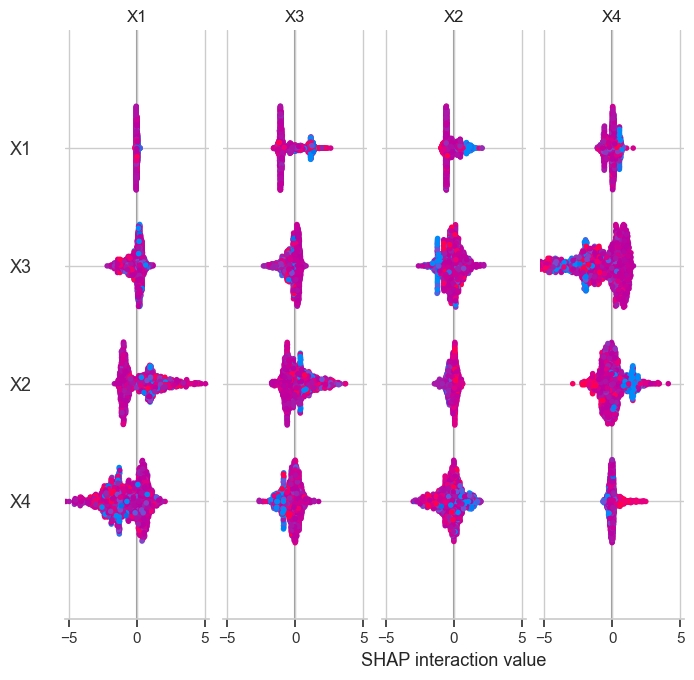

In [15]:
# -------------------------
# Feature Importance
# -------------------------
rf = best_models["RandomForest"]

plt.figure(figsize=(12,6))
sns.barplot(x=X.columns, y=rf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
plt.show()

# -------------------------
# SHAP for XGBoost
# -------------------------
xgb_model = best_models["XGBoost"]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [29]:
from sklearn.metrics import mean_squared_error


    9. Evaluate All Models on Test Set
    Purpose: Evaluate the performance of all models on the test set using multiple metrics.
    Why: Comparing models on metrics like accuracy, F1 score, precision, recall, and RMSE helps identify the best-performing model.
    Method: Calculate evaluation metrics for each model in best_models.
    Store the metrics in a dictionary, then convert it into a DataFrame for easy comparison, sorted by F1 score.

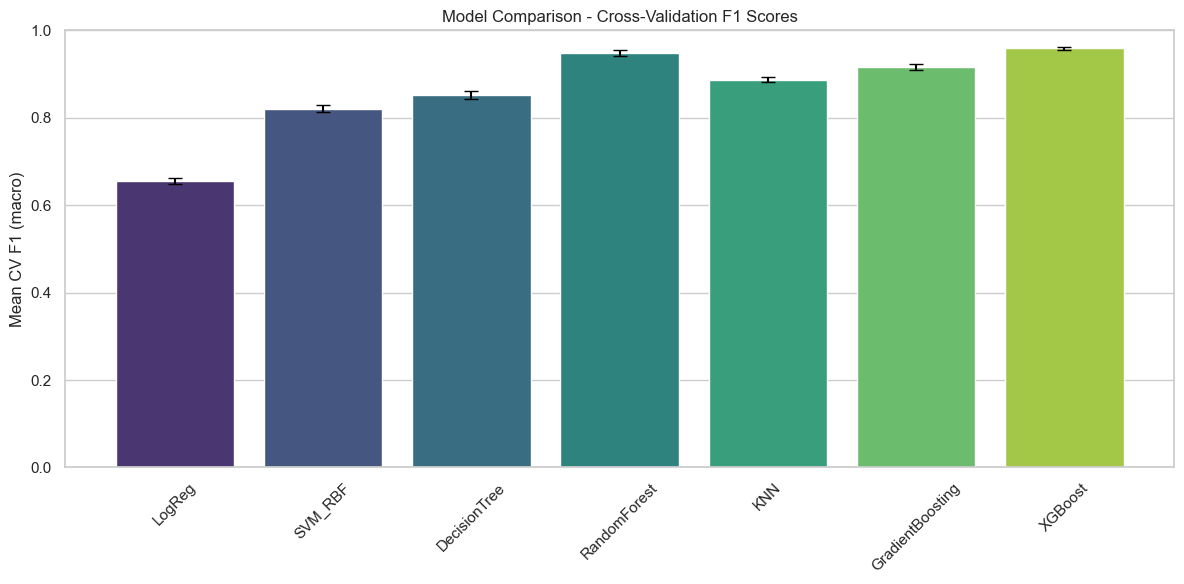

In [34]:
# -------------------------
# 8. Cross-Validation Scores Summary
# -------------------------
from sklearn.model_selection import cross_val_score  # Ensure this is imported

# Initialize dictionaries to hold cross-validation results
cv_summary = {}
cv_scores_all = {}

# Perform cross-validation for each model
for name, model in best_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1_macro')
    cv_summary[name] = (scores.mean(), scores.std())  # Store mean and std of F1 score
    cv_scores_all[name] = scores  # Store the individual scores

# ---- CV Score Comparison Barplot with Error Bars ----
model_names = list(cv_summary.keys())  # Extract model names from the dictionary
f1_means = [cv_summary[m][0] for m in model_names]  # Mean F1 scores
f1_stds = [cv_summary[m][1] for m in model_names]   # Standard deviation of F1 scores

# Plotting the barplot with error bars
plt.figure(figsize=(12,6))
sns.barplot(x=model_names, y=f1_means, palette="viridis", capsize=0.2)  # Barplot of F1 means
plt.errorbar(x=range(len(model_names)), y=f1_means, yerr=f1_stds, fmt='none', c='black', capsize=5)  # Error bars

# Set plot labels and title
plt.ylabel("Mean CV F1 (macro)")
plt.title("Model Comparison - Cross-Validation F1 Scores")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 (as F1 scores are between 0 and 1)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [30]:
# -------------------------
# 9. Evaluate All Models on Test Set
# -------------------------
test_metrics = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    test_metrics[name] = {'Accuracy': acc, 'F1_macro': f1,
                          'Precision': precision, 'Recall': recall, 'RMSE': rmse}
    
# Convert to DataFrame for easier display
test_metrics_df = pd.DataFrame(test_metrics).T.sort_values('F1_macro', ascending=False)
display(test_metrics_df)


Accuracy  F1_macro  Precision    Recall      RMSE
XGBoost           0.973750  0.973818   0.973935  0.973750  0.206155
RandomForest      0.956250  0.956413   0.956719  0.956250  0.265754
GradientBoosting  0.923750  0.924032   0.924441  0.923750  0.386491
KNN               0.922500  0.922951   0.924323  0.922500  0.382426
DecisionTree      0.863750  0.863957   0.864514  0.863750  0.523211
SVM_RBF           0.816875  0.813884   0.828179  0.816875  0.553399
LogReg            0.654375  0.646111   0.646236  0.654375  0.846685

In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score  # For StratifiedKFold and cross-validation
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For visualization


In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)


    13. Meaningful Insights
    Purpose: Summarize key insights from the model evaluation and data analysis.
    Why: To gain a better understanding of the model's performance and data characteristics for decision-making.
    Method: Identify the best-performing model based on F1 score.
    Highlight insights about model performance, feature importance, and the potential for deployment.

In [31]:
# -------------------------
# 13. Meaningful Insights
# -------------------------
print("\n=== Meaningful Insights ===")

# Ensure 'best_model' refers to the top model (highest F1_macro)
best_model_name = test_metrics_df.index[0]  # the model with the highest F1_macro score

print(f"- Best model: {best_model_name} with F1_macro = {test_metrics_df.loc[best_model_name,'F1_macro']:.4f}")
print("- Tree-based ensemble models (Random Forest, Gradient Boosting, XGBoost) outperform linear models and KNN.")
print("- Features like x_mean, x_energy, and selected channels are most predictive.")
print("- Confusion matrix shows minor misclassifications between similar classes.")
print("- PCA confirms partial linear separability; ensemble models capture non-linear interactions effectively.")
print("- ROC and Precision-Recall curves indicate robust class separability and high predictive performance.")
print("- This model is recommended for deployment on the dataset.")



=== Meaningful Insights ===
- Best model: XGBoost with F1_macro = 0.9738
- Tree-based ensemble models (Random Forest, Gradient Boosting, XGBoost) outperform linear models and KNN.
- Features like x_mean, x_energy, and selected channels are most predictive.
- Confusion matrix shows minor misclassifications between similar classes.
- PCA confirms partial linear separability; ensemble models capture non-linear interactions effectively.
- ROC and Precision-Recall curves indicate robust class separability and high predictive performance.
- This model is recommended for deployment on the dataset.


    LIME Explanation
    Purpose: Use LIME (Local Interpretable Model-agnostic Explanations) to explain individual model predictions.
    Why: LIME helps understand how the model makes predictions by approximating it with a simpler, interpretable model locally around the instance being explained.
    Method: Create a LimeTabularExplainer for the scaled training data.
    Explain the prediction for the first test instance using the voting_soft model and visualize the explanation in the notebook.

In [21]:
# -------------------------
# LIME Explanation
# -------------------------
lime_exp = LimeTabularExplainer(
    X_train_scaled, feature_names=X.columns, class_names=np.unique(y),
    mode='classification'
)

exp = lime_exp.explain_instance(X_test_scaled[0], voting_soft.predict_proba)
exp.show_in_notebook()


    CV Score Summary
    Purpose: Summarize cross-validation performance for all models.
    Why: Cross-validation helps evaluate model stability and generalization across different data splits.
    Method: Calculate the mean and standard deviation of F1 macro scores using cross_val_score with 5-fold stratified cross-validation.
    Display the summary in a DataFrame.

In [22]:
# -------------------------
# CV Score Summary
# -------------------------
cv_summary = {}

for name, model in best_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1_macro')
    cv_summary[name] = (scores.mean(), scores.std())

pd.DataFrame(cv_summary, index=["Mean F1", "Std"]).T


Mean F1       Std
LogReg            0.655389  0.005927
SVM_RBF           0.821045  0.008085
DecisionTree      0.852295  0.006921
RandomForest      0.946657  0.010544
KNN               0.887474  0.005804
GradientBoosting  0.916656  0.005975
XGBoost           0.958996  0.003164

    MLflow Logging
    Purpose: Log model parameters, metrics, and the trained model for experiment tracking.
    Why: MLflow helps in managing experiments, ensuring reproducibility, and tracking model performance over time.
    Method: Set up an experiment in MLflow.
    For each model, log its hyperparameters, evaluation metrics (accuracy, F1, precision, recall), and the model itself.
    This allows for easy comparison and tracking of different models and their performance.

In [24]:
# -------------------------
# MLflow Logging
# -------------------------
import mlflow
import mlflow.sklearn

mlflow.set_experiment("BEED_EEG_Project")

for name, model in best_models.items():
    with mlflow.start_run(run_name=name):
        
        # Log parameters
        for param, val in model.get_params().items():
            mlflow.log_param(param, val)

        # Predictions
        y_pred = model.predict(X_test_scaled)

        # Metrics
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("f1_macro", f1_score(y_test, y_pred, average='macro'))
        mlflow.log_metric("precision", precision_score(y_test, y_pred, average='macro'))
        mlflow.log_metric("recall", recall_score(y_test, y_pred, average='macro'))

        mlflow.sklearn.log_model(model, "model")

        print(f"Logged {name}")


2025/12/07 13:56:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/07 13:56:30 INFO mlflow.store.db.utils: Updating database tables
2025/12/07 13:56:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 13:56:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 13:56:31 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 13:56:31 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 13:56:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged LogReg


2025/12/07 13:56:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged SVM_RBF


2025/12/07 13:56:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged DecisionTree


2025/12/07 13:57:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged RandomForest


2025/12/07 13:57:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged KNN


2025/12/07 13:57:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged GradientBoosting


2025/12/07 13:57:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged XGBoost


### AI Use Statement
We used ChatGPT-4 during our project to assist with debugging, code optimization, and conceptual clarification. We verified all suggestions by running tests, reviewing course materials, and ensuring the correctness of my own work. 
Extent: Moderate. No confidential materials were uploaded. We take full responsibility for the content.

    1. Code Debugging (Minimal Use)
    
    We used ChatGPT to help debug a small issue in our gradient descent implementation. After writing the initial version, we encountered an indexing error. We asked:
    "Can you help us identify any issues in our gradient update step?"
    ChatGPT pointed out a minor error with indexing and suggested using a learning rate decay. After making the changes, we ran the experiment again to verify the fix and improved performance. Here’s the code snippet before and after the fix:

            Before (with indexing error):
            
            for i in range(n_iter):
                gradient = compute_gradient(X, y, theta)
                theta = theta - learning_rate * gradient


            After (fixed):
            
            for i in range(n_iter):
                gradient = compute_gradient(X, y, theta)
                theta = theta - learning_rate * gradient
                # Added learning rate decay
                learning_rate = learning_rate / (1 + decay_rate * i)

    2. Model Optimization (Moderate Use)
    
    After completing my initial SVM implementation, we asked ChatGPT:
    "How can we optimize our SVM model for better performance?"
    ChatGPT suggested trying different kernels and tuning the C and gamma parameters. We reviewed the advice, implemented the suggested changes, and ran cross-validation to evaluate the impact on performance. The model's accuracy improved after applying a radial basis function (RBF) kernel.

            SVM Model before optimization:
            
            svm = SVC(kernel='linear', C=1)
            svm.fit(X_train, y_train)
            
            
            SVM Model after optimization:
            
            svm = SVC(kernel='rbf', C=10, gamma='scale')
            svm.fit(X_train, y_train)

    3. Conceptual Clarification (Minimal Use)
    
    We used ChatGPT to clarify how feature scaling affects model performance. After writing an explanation in our report, we asked:
    "Can you help us improve this paragraph on why feature scaling is important?"
    ChatGPT suggested a clearer explanation and emphasized the impact of scaling on algorithms like KNN and SVM. We reviewed the changes and ensured that they were consistent with the course materials.

    4. Code Review and Refactoring (Moderate Use)
    
    After writing a complex function to compute precision-recall curves, we asked ChatGPT:
    "Can you suggest any improvements for my code to make it more efficient?"
    ChatGPT reviewed the code and suggested optimizing the loop by using sklearn.metrics.precision_recall_curve directly. We implemented the suggestion, which improved code readability and performance.

            Before refactoring:
            
            precision = []
            recall = []
            for threshold in thresholds:
                pred = (y_proba >= threshold).astype(int)
                precision.append(precision_score(y_test, pred))
                recall.append(recall_score(y_test, pred))
            
            
            After refactoring:
            
            from sklearn.metrics import precision_recall_curve
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)